# Modelling neural connectivity from fMRI data using  Bayesian Networks
### by Mattia Orlandi

This project was developed as part of the **Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3)** course of the **Master in Artificial Intelligence** (*Alma Mater Studiorum, University of Bologna*).

## Introduction
*Functional magnetic resonance imaging* (**fMRI**) is a neuro-imaging technique which measures brain activity by detecting changes in the blood flow: in fact, when a specific brain region is in use, the blood flow in that region will increase, creating the so-called *blood-oxygen-level dependent* (**BOLD**) signal.
Such signal is the result of a superimposition of the activities of several local regions.

The aim of this project is to use discrete Dynamic Bayesian Networks (dDBNs) to analyse the BOLD signal of an fMRI in order to estimate a model for neural connectivity, and thus show how the brain regions involved interacts with each other; to do so, the *movie watching based brain development* dataset [[1](#first)], composed of fMRI data from both children and adults collected during a movie-watching task, is considered.

## Data preprocessing

Firstly, the dataset is fetched using Nilearn APIs. In particular, the data concerning only 30 subjects out of 155 is loaded.

In [1]:
from nilearn import datasets
import warnings
warnings.filterwarnings('ignore')

# Fetch dataset
data = datasets.fetch_development_fmri(n_subjects=30, age_group='adult', data_dir='.')
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

As it can be seen, the dataset is a dictionary containing four keys:
- **func**: paths to Nifti files, containing the downsampled fMRI (4D) images for each subject;
- **confounds**: paths to CSV files containing the nuisance variables (i.e. *confounds*) to take into account in order not to affect the analysis;
- **phenotypic**: information about subjects (e.g. age, age group, gender, etc.);
- **description**: a description of the dataset.

As previously mentioned, fMRI signal is the summation of the signals coming from multiple regions; therefore, the next step consists in separating such signal into simpler, non-overlapping spatial and time components. This can be done using **Canonical Independent Component Analysis** (*CanICA*) [[2](#second)]: Nilearn provides the `CanICA` class which implements such algorithm. A 20-component decomposition was chosen according to Nilearn's documentation.

In [2]:
from nilearn.decomposition import CanICA

# Perform Independent Component Analysis (ICA)
canica = CanICA(n_components=20,
                mask_strategy='template',
                verbose=1,
                memory="nilearn_cache",
                memory_level=1,
                random_state=42)
canica.fit(data.func)

# Retrieve the components
components_img = canica.components_img_

[MultiNiftiMasker.fit] Loading data from [./development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz, ./development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_d
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Once the components have been extracted, it's possible to plot the ICs using two Nilearn functions: `plot_prob_atlas()` stacks all the ICs as layers on top of the default anatomical brain image, whereas `plot_stat_map()` allows to plot cuts of the region of interest (ROI).

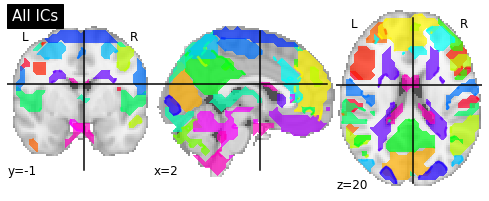

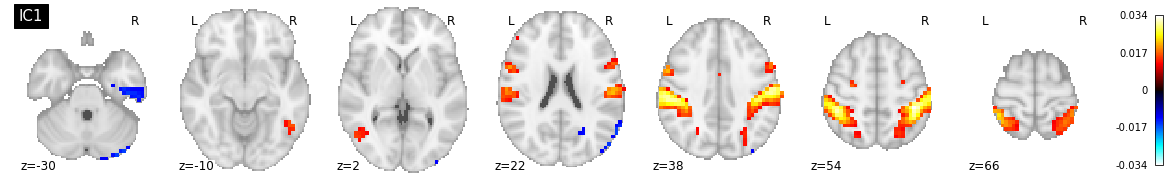

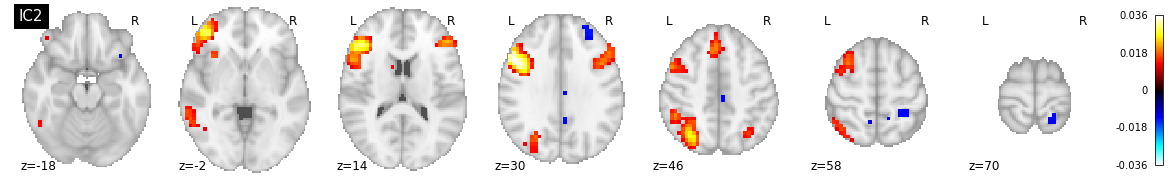

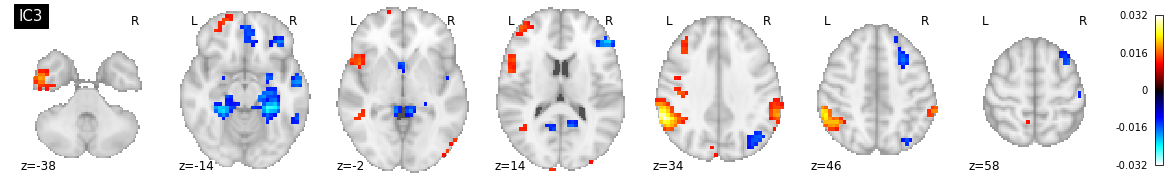

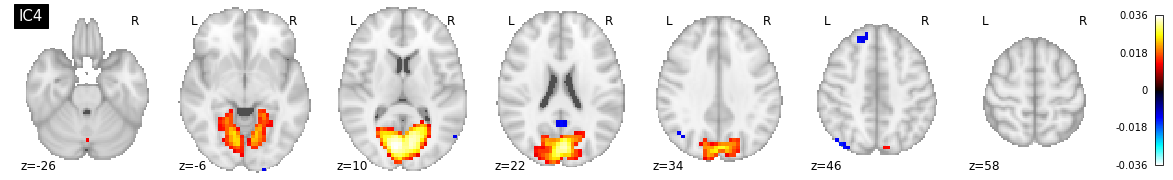

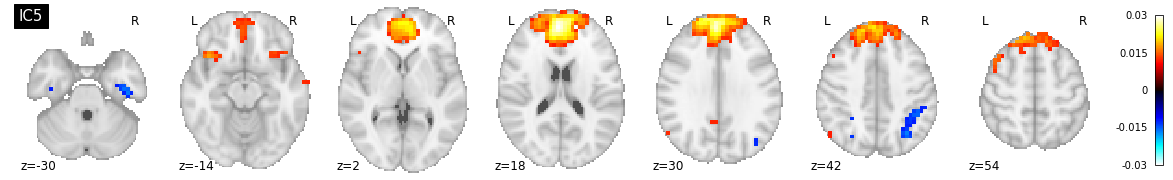

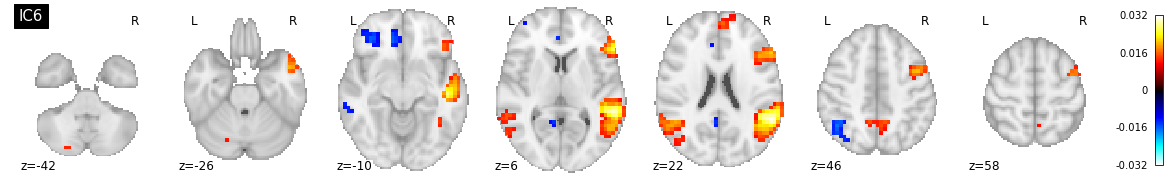

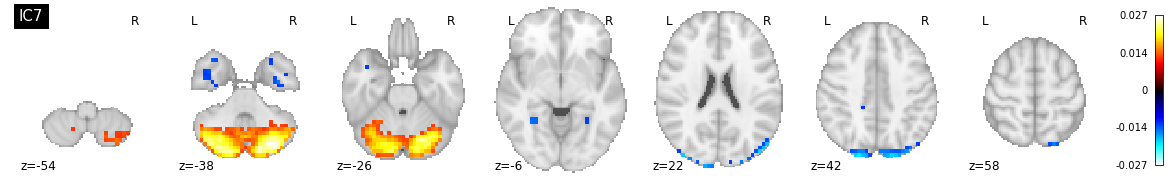

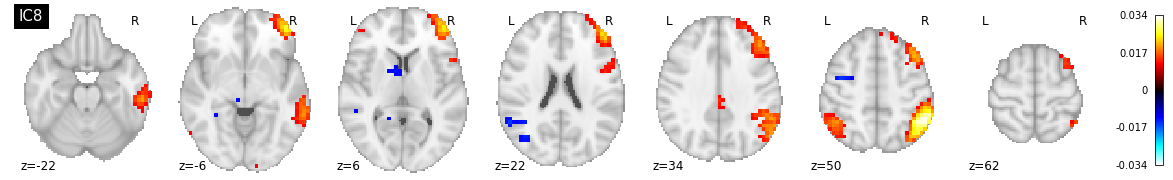

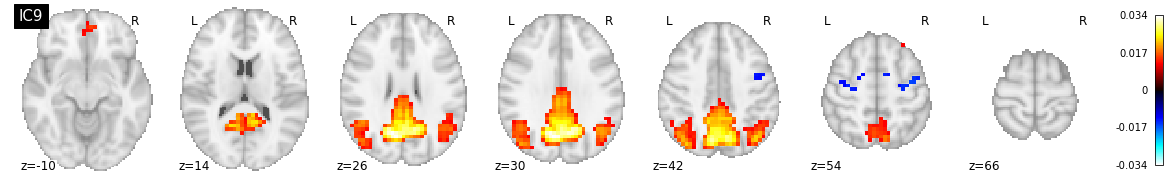

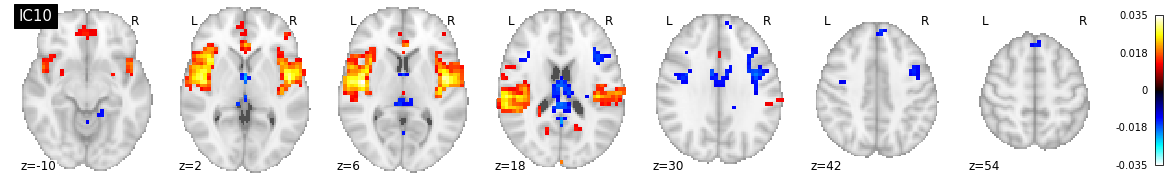

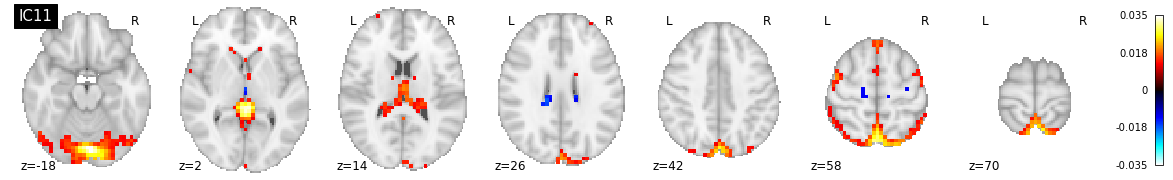

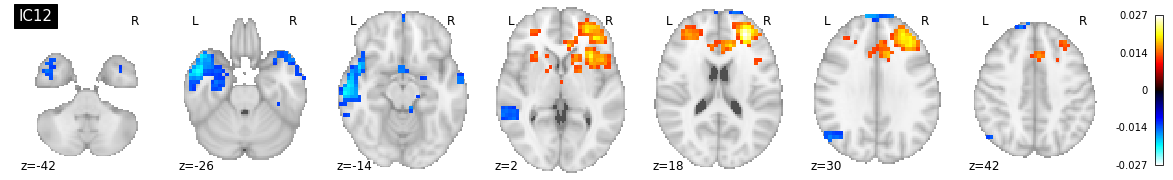

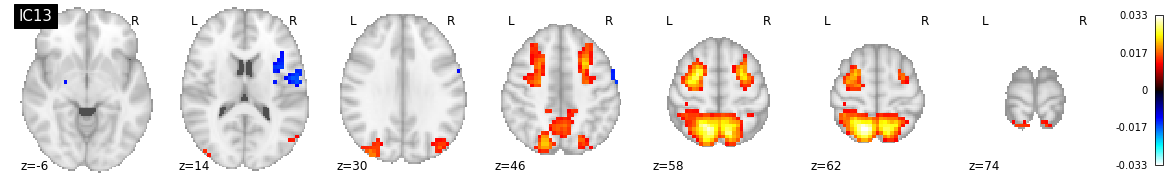

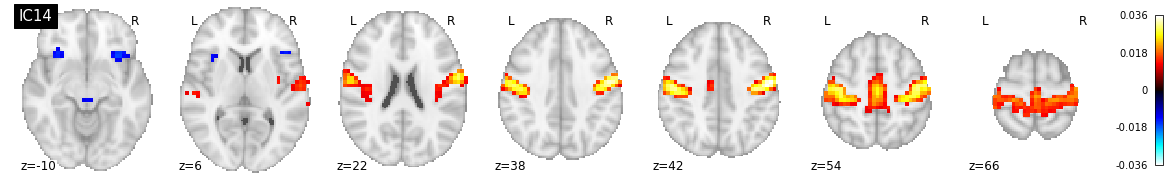

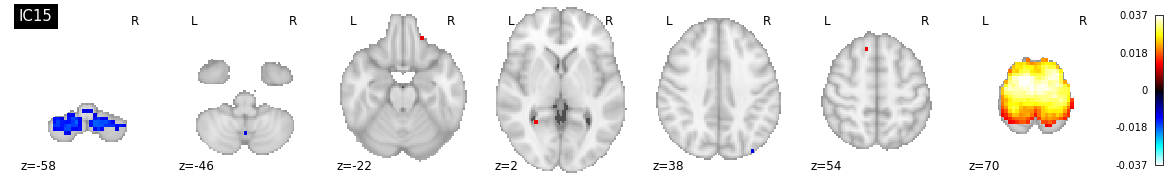

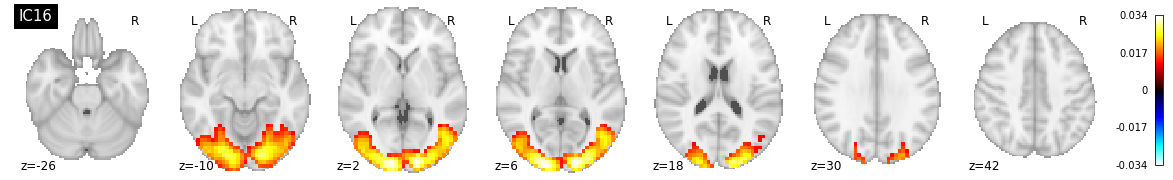

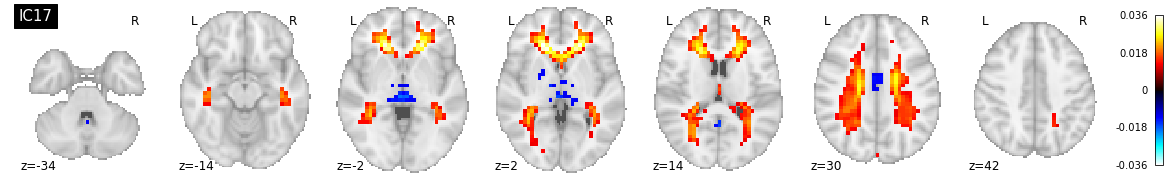

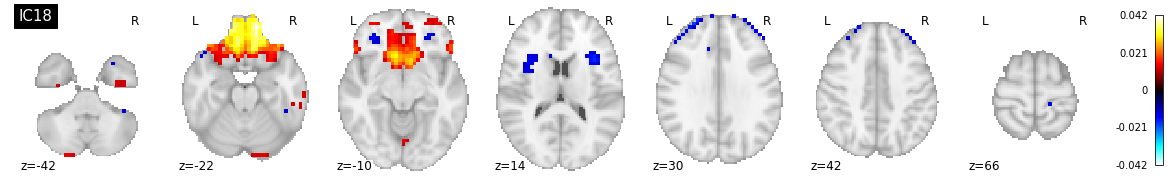

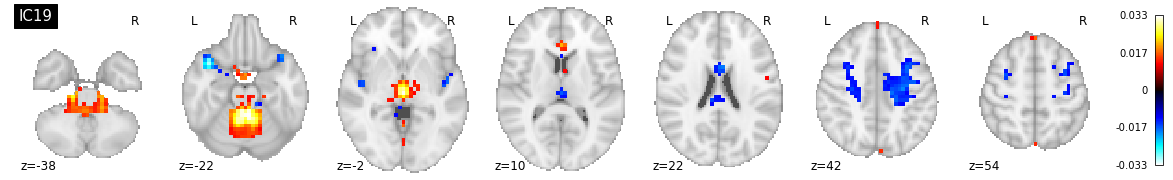

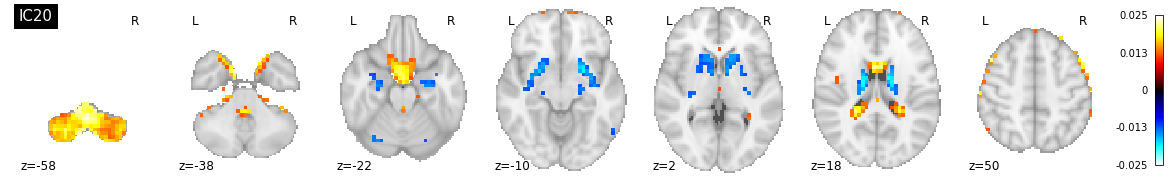

In [3]:
from nilearn import image, plotting

# Plot all ICs in a single image
plotting.plot_prob_atlas(components_img, title='All ICs')
plotting.show()

# Plot every IC in a separate image
for i, cur_img in enumerate(image.iter_img(components_img)):
    plotting.plot_stat_map(cur_img,
                           display_mode="z",
                           title=f'IC{i + 1}')

Then, the time series representing the signal must be extracted from each region; this can be done using the `NiftiMapsMasker` filter, and its `fit_transform()` function.

In [4]:
from nilearn.input_data import NiftiMapsMasker
import numpy as np

# Initialize masker
masker = NiftiMapsMasker(components_img,
                         standardize=True,
                         verbose=1,
                         memory="nilearn_cache",
                         memory_level=2)

# Extract time series
time_series = []
for func_file, confound_file in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func_file, confounds=confound_file))

print('-' * 50)
print(f'Number of subjects: {len(time_series)}')

# Take the mean signal w.r.t. the subjects
time_series = np.mean(time_series, axis=0)

print(f'Length of time series: {time_series.shape[0]}')
print(f'Number of regions: {time_series.shape[1]}')

[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image(
shape=(50, 59, 50, 20),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image(
shape=(50, 59, 50, 20),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image(
shape=(50, 59, 50, 20),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image(
shape=(50, 59, 50, 20),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMa

________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_maps_masker.nifti_maps_masker_extractor...
nifti_maps_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7fe1b454bd90>)
______________________________________nifti_maps_masker_extractor - 4.2s, 0.1min
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
_______________________________________________filter_and_extract - 5.5s, 0.1min
[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image(
shape=(50, 59, 50, 20),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
--------------------------------------------------
Number of subjects: 30
Length of time series: 168
Number of regions: 20


After taking the mean of each time series w.r.t. the 30 subjects, the data is stored in a ```pandas.DataFrame``` object: each column represents the region of the brain in which the signal was measured, and each row represents a time step.

In [5]:
import pandas as pd

labels = [f'IC{i + 1}' for i in range(time_series.shape[1])]

# Create dataframe of time series
list_of_series = [pd.Series(t) for t in time_series.T]
df = pd.concat(list_of_series, axis=1)
df.columns = labels

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20
0,-0.070332,0.204811,1.189540,-1.690648,0.263276,-0.515327,0.655382,0.581924,-0.652063,1.124909,-0.347791,0.458999,-0.168210,0.501121,0.572004,-1.919812,0.404742,-0.060318,-0.017412,-0.010854
1,-0.132431,-0.019691,0.904434,-1.338158,0.483361,-0.534366,0.876356,0.772279,-0.376868,0.752634,-0.454730,0.776528,-0.388313,0.333159,0.511710,-1.778874,0.577601,-0.295195,-0.052546,-0.260002
2,-0.168501,-0.101634,0.771214,-0.186955,0.485317,-0.571614,0.694622,0.460176,0.157179,0.054420,-0.663160,0.636831,-0.209595,0.329643,0.381883,-1.777255,0.315870,-0.513095,0.300544,-0.106014
3,-0.283499,0.039049,0.835157,0.214592,0.425403,-0.629265,0.310630,0.440717,0.312170,0.003712,-0.474660,0.269367,-0.155179,0.269776,-0.139876,-1.984131,0.074195,0.034853,0.004655,-0.379087
4,-0.102474,0.024157,1.027986,0.153346,0.337415,-0.767088,0.306284,0.735634,0.527629,0.186342,-0.082288,0.657151,0.027974,0.450538,0.307308,-2.092789,0.092654,-0.394252,0.258575,-0.260011
5,-0.212737,-0.116836,1.112523,0.141197,0.036922,-0.765230,0.197846,0.390159,0.343681,0.357268,-0.349707,0.707515,-0.074038,0.139127,0.172690,-2.221699,0.065130,-0.171588,0.506528,-0.206129
6,-0.185445,-0.308778,0.960531,-0.349698,0.574372,-0.705888,0.203433,0.296495,0.014151,0.370986,-0.670679,0.656382,-0.258242,0.173926,0.141660,-2.543365,0.301687,-0.427180,0.013797,-0.245368
7,-0.192236,-0.139222,0.216979,-0.285155,0.318126,-0.753888,0.126699,-0.003856,-0.113322,-0.049565,-1.084366,0.603289,-0.444412,-0.102672,0.210764,-1.732295,0.249283,-0.122078,-0.068940,-0.061058
8,-0.345819,0.272784,-0.435394,-0.278786,0.177084,-0.626635,0.055262,0.035736,0.032073,-0.600935,-0.931595,0.200961,-0.499367,-0.348269,-0.046443,-0.558223,0.060708,-0.122673,-0.367330,-0.347829
9,-0.460006,0.402885,-0.398193,0.069581,-0.035133,-0.486072,0.115138,0.073388,-0.234807,-0.528005,-0.439253,0.059186,-0.668196,-0.483637,-0.341955,0.066221,-0.130521,0.052536,-0.274167,-0.467456


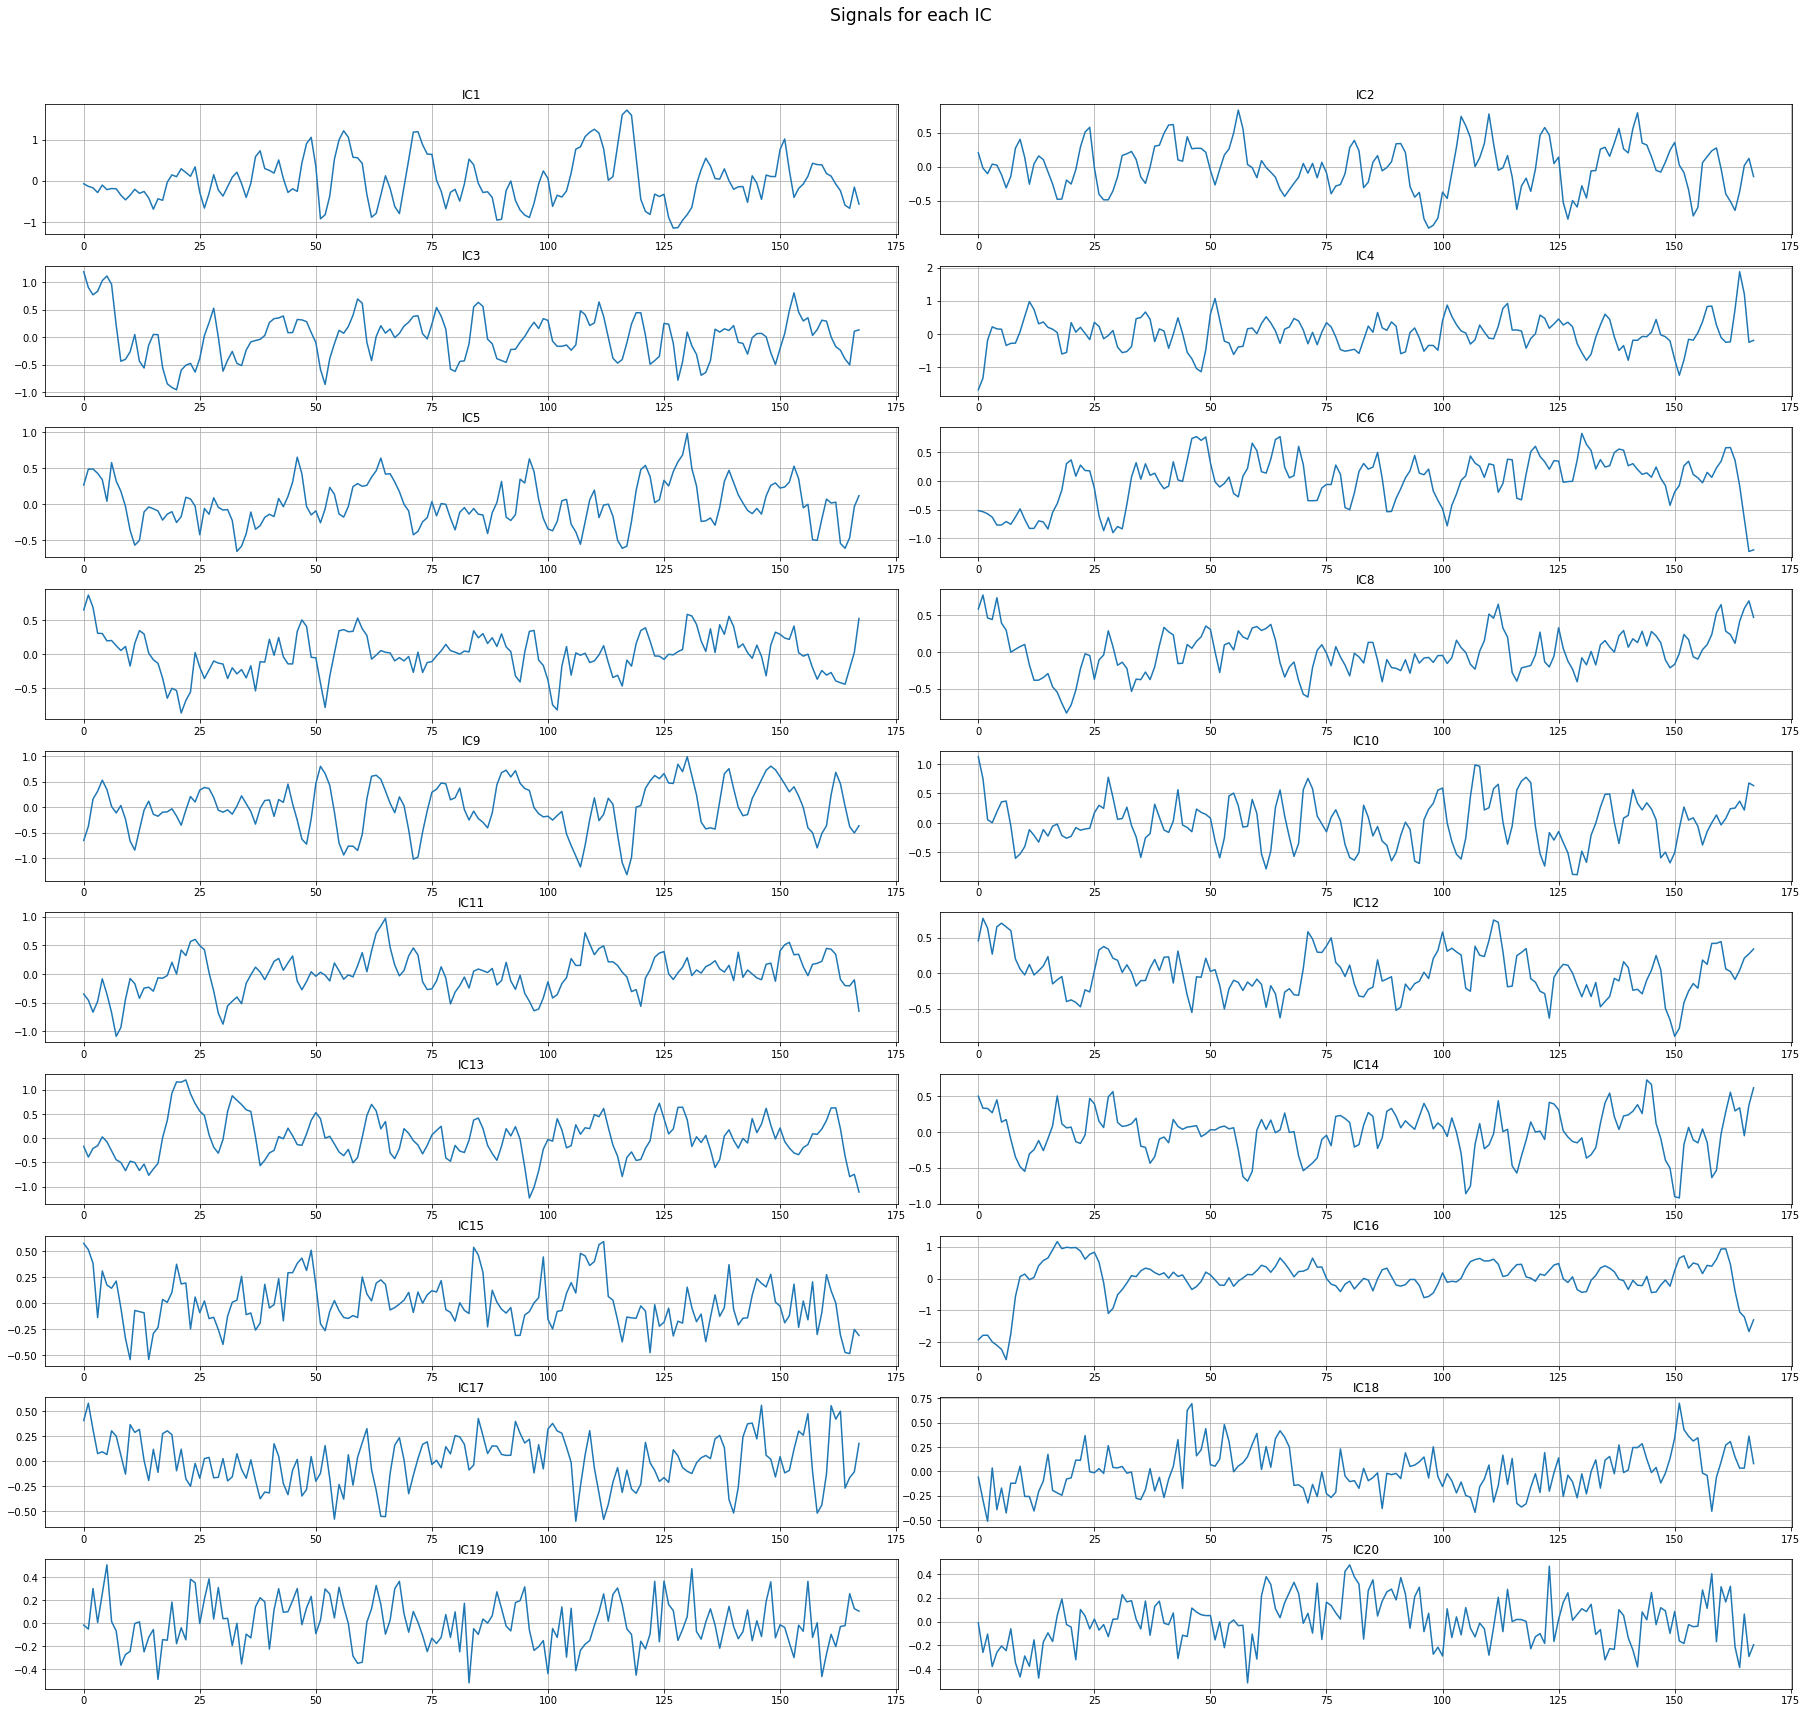

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

_, axes = plt.subplots(nrows=10, ncols=2, figsize=(25, 25))
plt.suptitle('Signals for each IC', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for i, col in enumerate(df):
    id1 = i // 2
    id2 = i % 2
    df[col].plot(ax=axes[id1, id2], grid=True, title=col)

Since the aim of the project is developing a discrete DBN, the signal must be discretized; before doing so, the signal is normalized s.t. it will have mean $\mu=0$ and standard deviation $\sigma=1$ [[3](#third)]. 

In [7]:
# Normalize dataframe
df = (df - df.mean()) / df.std()

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20
0,-0.121601,0.584190,2.889420,-3.463585,0.842179,-1.184423,2.121410,1.973557,-1.375686,2.766975,-1.027234,1.441043,-0.382293,1.614955,2.428392,-3.046777,1.613120,-0.266531,-0.084079,-0.053514
1,-0.228966,-0.056166,2.196891,-2.741448,1.546200,-1.228182,2.836682,2.619130,-0.795095,1.851279,-1.343090,2.437937,-0.882526,1.073665,2.172418,-2.823107,2.302056,-1.304396,-0.253736,-1.281932
2,-0.291330,-0.289894,1.873297,-0.383009,1.552455,-1.313794,2.248426,1.560656,0.331608,0.133859,-1.958708,1.999352,-0.476351,1.062334,1.621251,-2.820536,1.258916,-2.267243,1.451283,-0.522697
3,-0.490156,0.111380,2.028615,0.439629,1.360801,-1.446299,1.005480,1.494662,0.658599,0.009131,-1.401956,0.845688,-0.352678,0.869402,-0.593832,-3.148852,0.295708,0.154005,0.022479,-1.869073
4,-0.177172,0.068905,2.497002,0.314155,1.079339,-1.763069,0.991413,2.494853,1.113161,0.458351,-0.243045,2.063148,0.063577,1.451941,1.304647,-3.321295,0.369276,-1.742105,1.248622,-1.281973
5,-0.367812,-0.333257,2.702345,0.289266,0.118108,-1.758798,0.640407,1.323198,0.725079,0.878785,-1.032895,2.221267,-0.168267,0.448362,0.733142,-3.525877,0.259578,-0.758205,2.445950,-1.016309
6,-0.320625,-0.880739,2.333153,-0.716416,1.837330,-1.622408,0.658492,1.005544,0.029855,0.912526,-1.980917,2.060733,-0.586911,0.560507,0.601404,-4.036367,1.202388,-1.887608,0.066623,-1.209776
7,-0.332366,-0.397109,0.527047,-0.584190,1.017638,-1.732730,0.410113,-0.013077,-0.239081,-0.121916,-3.202782,1.894048,-1.010023,-0.330880,0.894778,-2.749184,0.993528,-0.539435,-0.332902,-0.301042
8,-0.597904,0.778071,-1.057581,-0.571142,0.566464,-1.440253,0.178877,0.121198,0.067667,-1.478140,-2.751559,0.630925,-1.134920,-1.122360,-0.197169,-0.885910,0.241956,-0.542062,-1.773784,-1.714958
9,-0.795328,1.149164,-0.967220,0.142550,-0.112385,-1.117185,0.372691,0.248891,-0.495382,-1.298750,-1.297378,0.185816,-1.518619,-1.558608,-1.451740,0.105093,-0.520200,0.232142,-1.323912,-2.304776


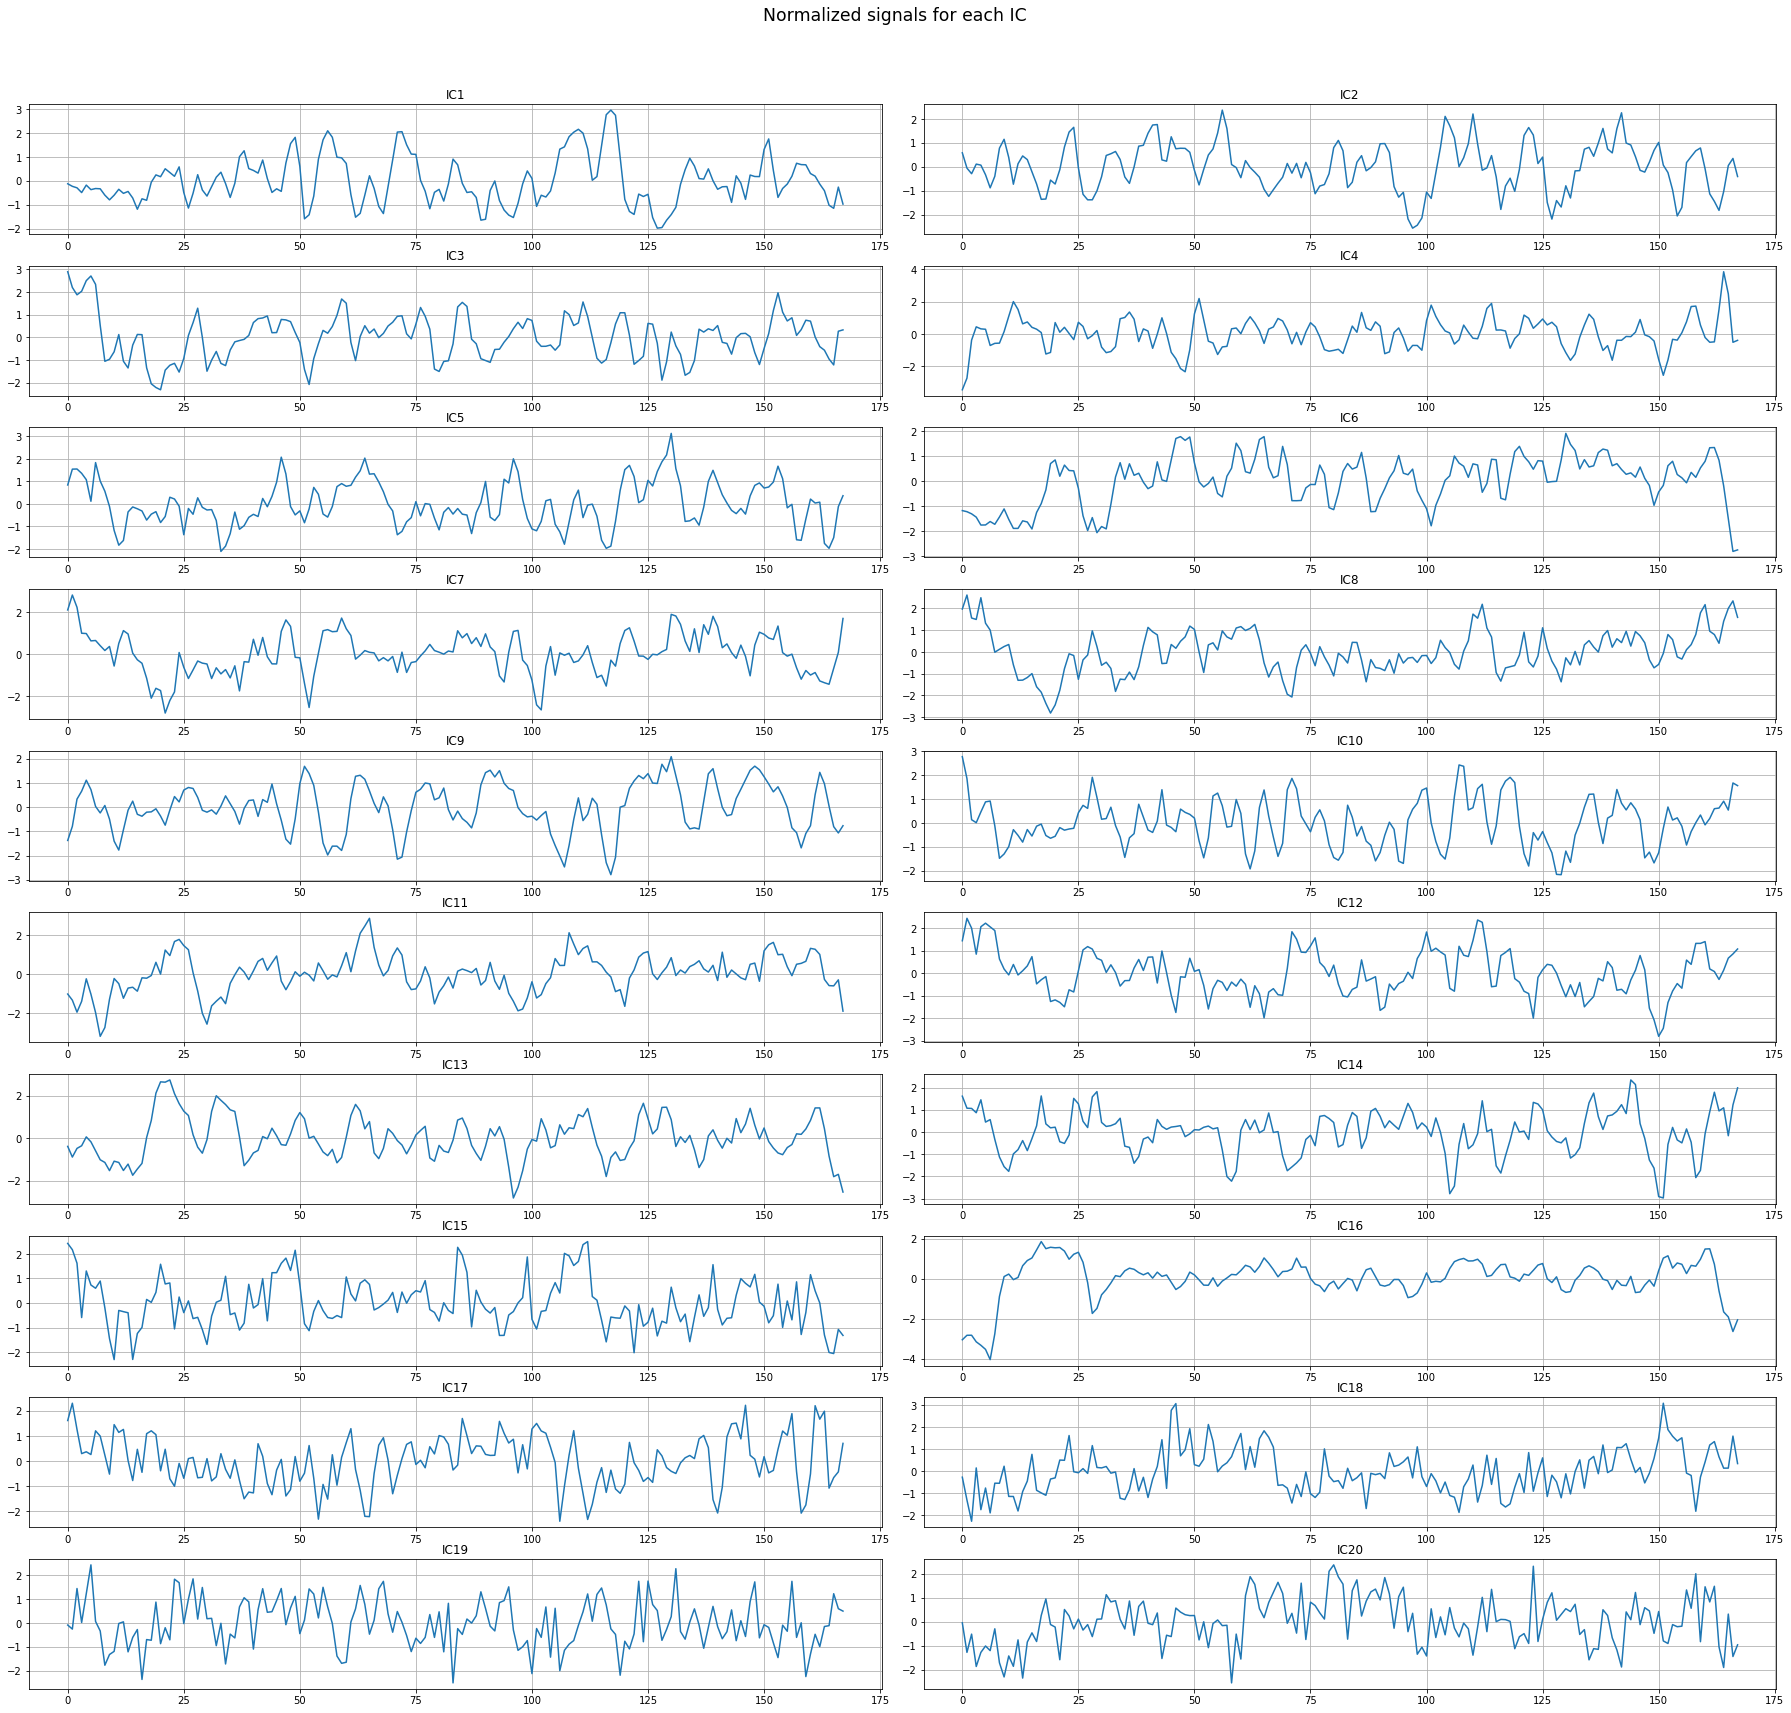

In [8]:
_, axes = plt.subplots(nrows=10, ncols=2, figsize=(25, 25))
plt.suptitle('Normalized signals for each IC', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for i, col in enumerate(df):
    id1 = i // 2
    id2 = i % 2
    df[col].plot(ax=axes[id1, id2], grid=True, title=col)

After the normalization, the signal is discretized using four tiers; given $V_{min}$ and $V_{max}$, respectively the minimum and maximum values across the time series, then the current continuous value of the signal $V_{cont}$ is discretized according to the following rules [[3](#third)]:
- 'Very Low' if $V_{cont} \lt \frac{V_{min}}{2}$;
- 'Low' if $\frac{V_{min}}{2} \leq V_{cont} \lt 0$;
- 'High' if $0 \leq V_{cont} \lt \frac{V_{max}}{2}$;
- 'Very High' if $V_{cont} \geq \frac{V_{max}}{2}$.

In [9]:
def discretize_series(series):
    # Find minimum and maximum values of the series, and define boundaries
    s_min, s_max = series.min(), series.max()
    boundaries = [s_min / 2., 0., s_max / 2.]
    
    # Assign tier based on the boundaries
    def get_tier(val):
        if val < boundaries[0]:
            return 'Very Low'
        elif val >= boundaries[0] and val < boundaries[1]:
            return 'Low'
        elif val >= boundaries[1] and val < boundaries[2]:
            return 'High'
        else:
            return 'Very High'
    
    return pd.Series([get_tier(val) for val in series])

list_of_series = [discretize_series(df[col]) for col in df]
df = pd.concat(list_of_series, axis=1)
df.columns = labels

df.head(10)

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20
0,Low,High,Very High,Very Low,High,Low,Very High,Very High,Low,Very High,Low,Very High,Low,Very High,Very High,Very Low,Very High,Low,Low,Low
1,Low,Low,Very High,Very Low,High,Low,Very High,Very High,Low,Very High,Low,Very High,Low,High,Very High,Very Low,Very High,Very Low,Low,Very Low
2,Low,Low,Very High,Low,High,Low,Very High,Very High,High,High,Very Low,Very High,Low,High,Very High,Very Low,Very High,Very Low,Very High,Low
3,Low,High,Very High,High,High,Very Low,High,Very High,High,High,Low,High,Low,High,Low,Very Low,High,High,High,Very Low
4,Low,High,Very High,High,High,Very Low,High,Very High,Very High,High,Low,Very High,High,Very High,Very High,Very Low,High,Very Low,Very High,Very Low
5,Low,Low,Very High,High,High,Very Low,High,Very High,High,High,Low,Very High,Low,High,High,Very Low,High,Low,Very High,Low
6,Low,Low,Very High,Low,Very High,Very Low,High,High,High,High,Very Low,Very High,Low,High,High,Very Low,Very High,Very Low,High,Low
7,Low,Low,High,Low,High,Very Low,High,Low,Low,Low,Very Low,Very High,Low,Low,High,Very Low,High,Low,Low,Low
8,Low,High,Low,Low,High,Very Low,High,High,High,Very Low,Very Low,High,Low,Low,Low,Low,High,Low,Very Low,Very Low
9,Low,High,Low,High,Low,Low,High,High,Low,Very Low,Low,High,Very Low,Very Low,Very Low,High,Low,High,Very Low,Very Low


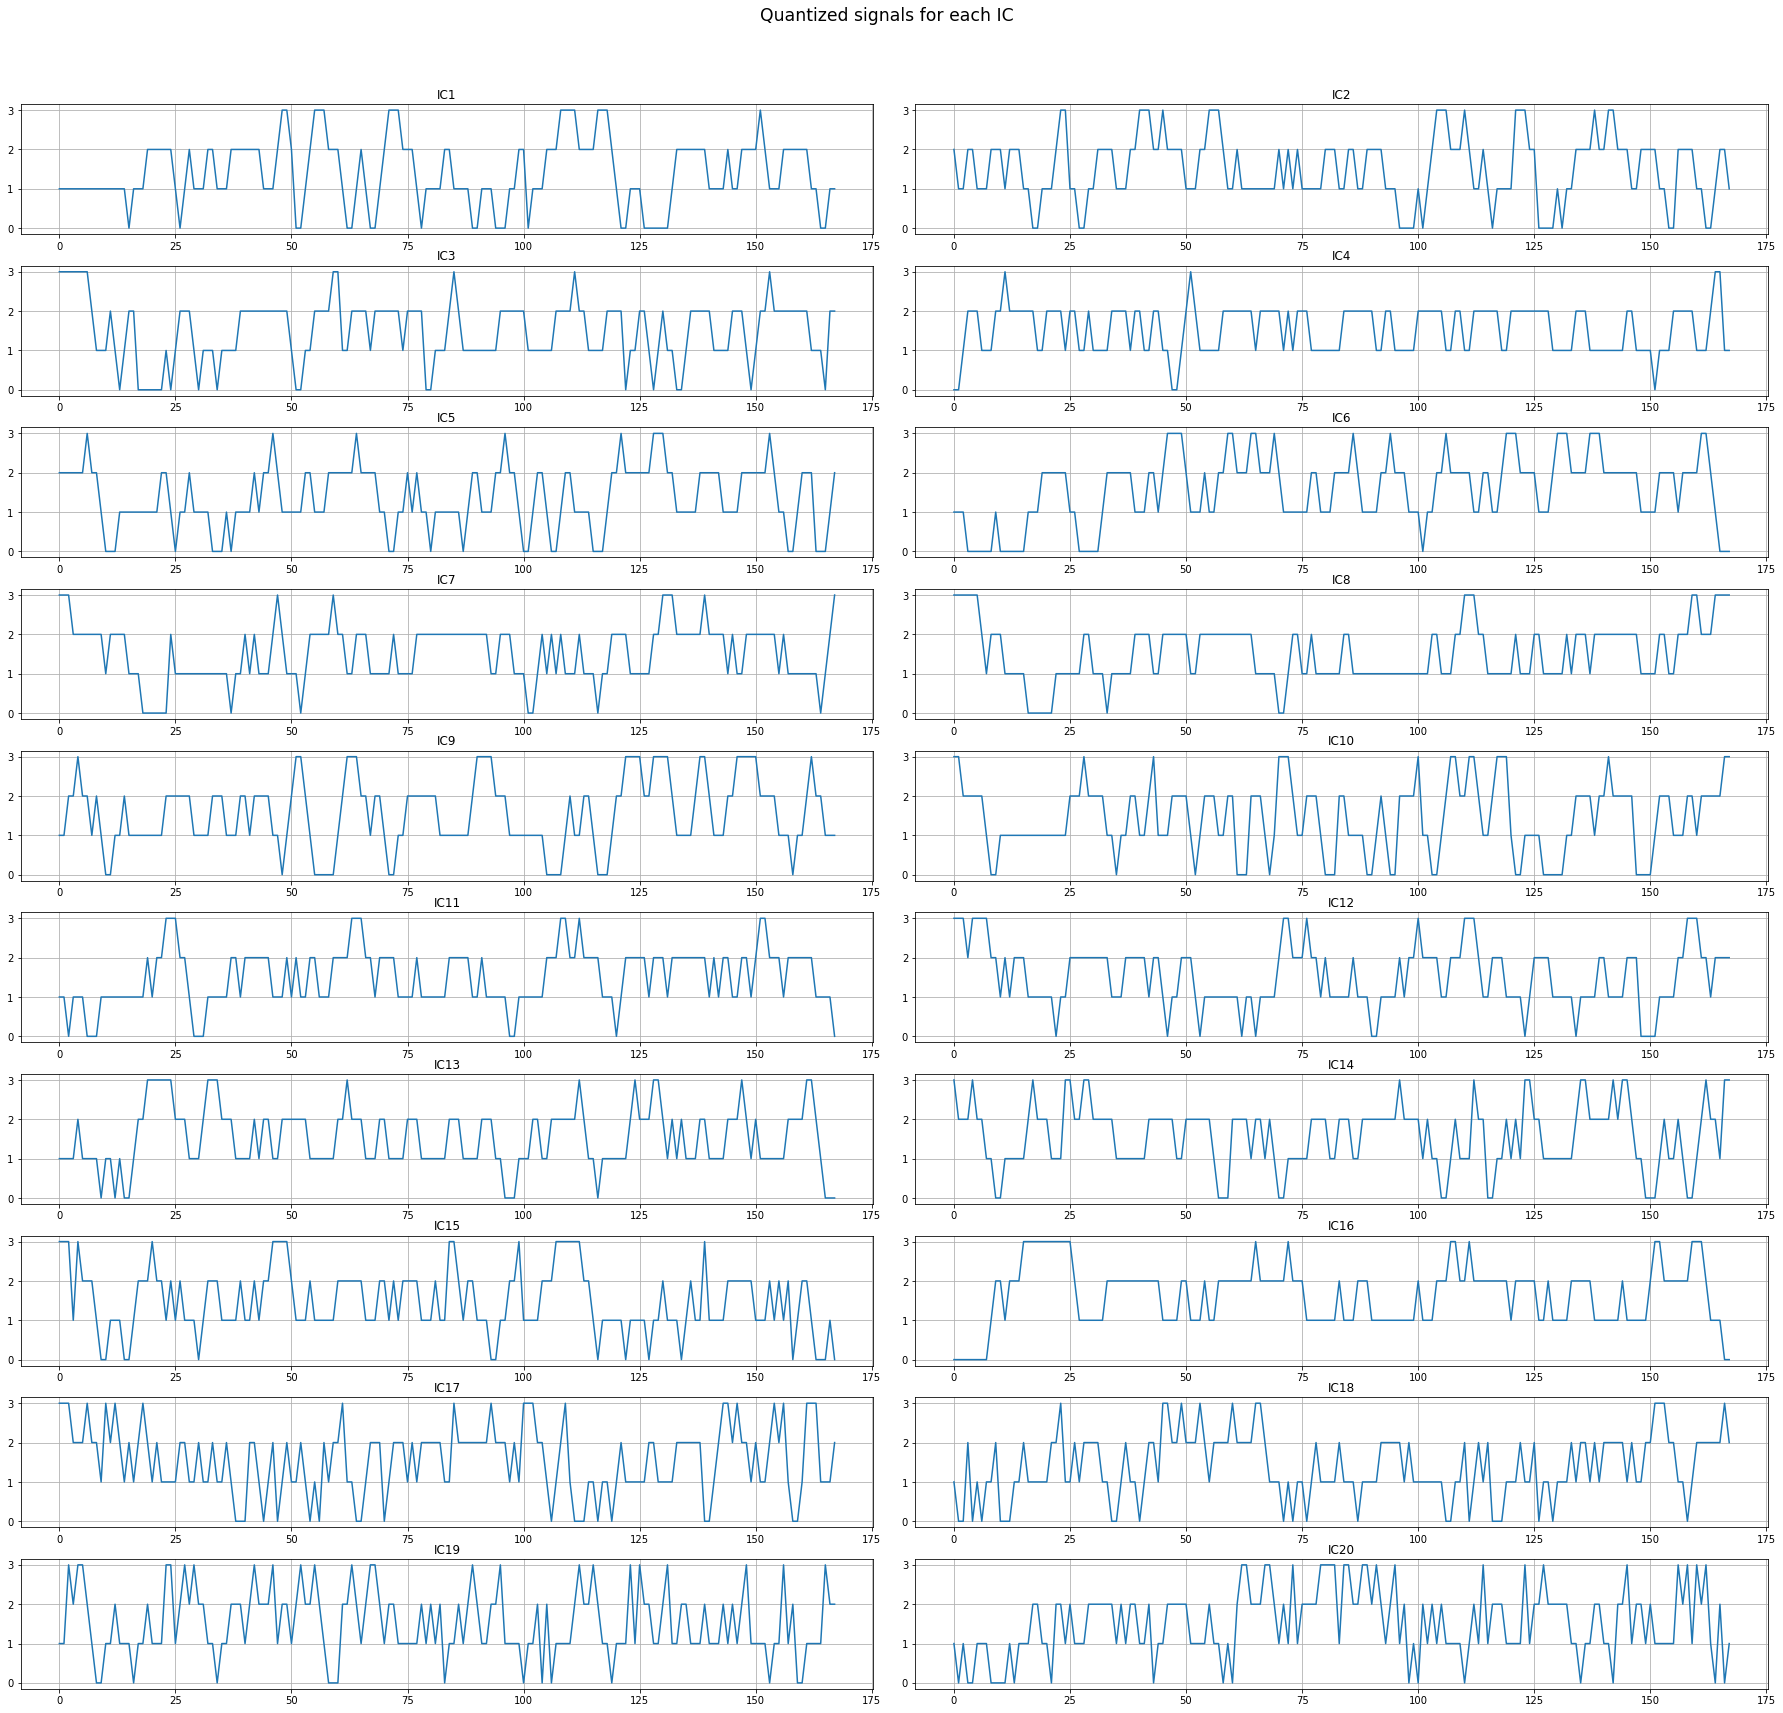

In [10]:
_, axes = plt.subplots(nrows=10, ncols=2, figsize=(25, 25))
plt.suptitle('Quantized signals for each IC', size='xx-large')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

quantize_enc = {'Very Low': 0,
                'Low': 1,
                'High': 2,
                'Very High': 3}
for i, col in enumerate(df):
    id1 = i // 2
    id2 = i % 2
    s = [quantize_enc[v] for v in df[col]]
    axes[id1, id2].plot(s)
    axes[id1, id2].set_title(col)
    axes[id1, id2].grid()

The dDBN that will be learnt is a 2-TBN, i.e. a discrete dynamic BN considering only 2 time slices. Therefore, the final preprocessing step consists in 'rolling' the dataset: the columns of the dataframe are doubled, s.t. the original columns will represent the value of the signal in the current time step, whereas the new ones will represent the value of the signal in the following time step. As a result, the length of each time series will be 167 instead of 168.

In [11]:
def roll_series(series):
    # Copy the original series
    next_series = series.copy()
    series = series[:-1].reset_index(drop=True)
    next_series = next_series[1:].reset_index(drop=True)
    return series, next_series

# Roll time series and flatten
list_of_series = [roll_series(df[col]) for col in df]
list_of_series = [v for t in list_of_series for v in t]
# Create new labels and flatten
new_labels = [(f'{l}_t', f'{l}_t+1') for l in labels]
new_labels = [l for t in new_labels for l in t]

# Create new dataframe
df = pd.concat(list_of_series, axis=1)
df.columns = new_labels

print(f'Length of the time series after rolling phase: {df.shape[0]}')
print('-' * 50)
df.head(10)

Length of the time series after rolling phase: 167
--------------------------------------------------


,IC1_t,IC1_t+1,IC2_t,IC2_t+1,IC3_t,IC3_t+1,IC4_t,IC4_t+1,IC5_t,IC5_t+1,...,IC16_t,IC16_t+1,IC17_t,IC17_t+1,IC18_t,IC18_t+1,IC19_t,IC19_t+1,IC20_t,IC20_t+1
0,Low,Low,High,Low,Very High,Very High,Very Low,Very Low,High,High,...,Very Low,Very Low,Very High,Very High,Low,Very Low,Low,Low,Low,Very Low
1,Low,Low,Low,Low,Very High,Very High,Very Low,Low,High,High,...,Very Low,Very Low,Very High,Very High,Very Low,Very Low,Low,Very High,Very Low,Low
2,Low,Low,Low,High,Very High,Very High,Low,High,High,High,...,Very Low,Very Low,Very High,High,Very Low,High,Very High,High,Low,Very Low
3,Low,Low,High,High,Very High,Very High,High,High,High,High,...,Very Low,Very Low,High,High,High,Very Low,High,Very High,Very Low,Very Low
4,Low,Low,High,Low,Very High,Very High,High,High,High,High,...,Very Low,Very Low,High,High,Very Low,Low,Very High,Very High,Very Low,Low
5,Low,Low,Low,Low,Very High,Very High,High,Low,High,Very High,...,Very Low,Very Low,High,Very High,Low,Very Low,Very High,High,Low,Low
6,Low,Low,Low,Low,Very High,High,Low,Low,Very High,High,...,Very Low,Very Low,Very High,High,Very Low,Low,High,Low,Low,Low
7,Low,Low,Low,High,High,Low,Low,Low,High,High,...,Very Low,Low,High,High,Low,Low,Low,Very Low,Low,Very Low
8,Low,Low,High,High,Low,Low,Low,High,High,Low,...,Low,High,High,Low,Low,High,Very Low,Very Low,Very Low,Very Low
9,Low,Low,High,High,Low,Low,High,High,Low,Very Low,...,High,High,Low,Very High,High,Very Low,Very Low,Low,Very Low,Very Low


## Structure learning
After the preprocessing phase, the data is ready to be used to learn the dDBN. However, since pgmpy does not support learning a dynamic BN, the model that will be learnt will be a static BN. This is possible thanks to the 'rolling' preprocessing step: in fact, the nodes belonging to the 'current' and 'next' time slices are treated as if they were standard nodes in a static BN. Therefore, the only things to keep in mind are the constraints due to the dynamic nature of the DBN [[4](#fourth)]:
- **causality constraint**: a node in the current time slice cannot be influenced by a node in the following time slice;
- **isochronal constraint**: a node in a time slice cannot influence other nodes in the same time slice;
- **continuity constraint**: a node in the current time slice will influence itself in the following time slice.

The search strategy employed is the **forward stepwise selection** [[3](#third)]:
- scan every 'next' node $X_n$;
- scan every 'current' node $X_c$;
- add $X_c$ as parent of $X_n$, measure structure score and remove such edge;
- re-add and keep only the edge producing the best score and repeat $indegree$ times.

Causality and isochronal constraints are already intrinsically taken into account by the search algorithm; on the other hand, continuity constraints are enforced when creating the initial model.

As in Burge et al.'s paper [[3](#third)], the *Bayesian Dirichlet equivalent uniform* prior (**BDeu**) score is used to assess the quality of a structure. Nevertheless, there are some differences in this implementation of forward stepwise selection w.r.t. the paper: in fact, the algorithm employed by Burge et al. also takes into account an additional node, representing the stimulus, connected to all the others; however, since in this case the stimulus (a movie) is active throughout all the fMRI recording, a node representing such stimulus would not carry any additional information, and thus it is not included. Moreover, Burge et al. do not impose any continuity constraint.

To speed-up the search, multi-core programming is exploited using `concurrent.futures.ProcessPoolExecutor` APIs. In particular, because of Python's lock mechanisms when importing modules, the code related to the worker must reside in a separate file `worker.py`; such script contains only one simple function, shown below:
```
def edge_eval(x_c, x_n, model, estimator):
    copy = model.copy()
    copy.add_edge(x_c, x_n)
    return estimator.score(copy)
```

In [12]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BDeuScore
from concurrent.futures import ProcessPoolExecutor
import time
import itertools
import psutil
from worker import edge_eval  # Because of Python's technical limitations on multi-processing, the code related to the worker must be in a separate .py file

# Divide nodes into two categories, 'current' (time slice t) and 'next' (time slice t+1)
c_nodes, n_nodes = [], []
for i, n in enumerate(new_labels):
    if i % 2 == 0:
        c_nodes.append(n)
    else:
        n_nodes.append(n)

# Create BDeu estimator with default parameters
est = BDeuScore(df)

def forward_stepwise_selection(current_nodes, next_nodes, indegree, estimator, verbose = False):
    start_time = time.time()
    
    # Initialize model with continuity constraints
    continuity_constraints = list(zip(current_nodes, next_nodes))
    model = BayesianModel(continuity_constraints)
    
    # Create support dictionary to find node ICX_t from ICX_t+1
    node_map = dict([(n, c) for c, n, in continuity_constraints])
    
    # Get number of physical cores
    n_procs = psutil.cpu_count(logical=False)
    if verbose:
        print(f'Using {n_procs} cores')
        print('-' * 50)
    
    # Scan next nodes
    for x_n in next_nodes:
        if verbose:
            print(f'Finding parents of node {x_n}...')
        
        added_nodes = set()
        # Take continuity constraints into account in the added nodes
        added_nodes.add(node_map[x_n])
        # Loop is repeated (indegree - 1) times since one parent node 
        # has already been added due to continuity constraints
        for _ in range(indegree - 1):
            testable_nodes = set(current_nodes).difference(added_nodes)
            # Use multiprocessing to speed-up search
            scores = dict()
            with ProcessPoolExecutor(max_workers=n_procs) as executor:
                # The repeat function allows to create an iterator which returns every time the same value;
                # this is needed to pass constants, since executor.map() accepts only iterables of the same length
                scores = dict(zip(testable_nodes, executor.map(edge_eval,
                                                               testable_nodes,
                                                               itertools.repeat(x_n),
                                                               itertools.repeat(model),
                                                               itertools.repeat(estimator))))
            node_to_add = max(scores, key=scores.get)
            best_score = scores[node_to_add]
            model.add_edge(node_to_add, x_n)
            added_nodes.add(node_to_add)
            if verbose:
                print(f'\t Added {node_to_add} with {best_score:.2f}')
    if verbose:
        print('-' * 50)
        print(f'Running time: {time.time() - start_time:.2f} s')
    return model, est.score(model)

The number of parents a 'next' node can have (i.e. $indegree$) is a hyper-parameter: it is possible to determine it using a grid search. The chosen parameter space is $[2..5]$: in particular, the lower bound forces one region to be connected to (at least) another one, in addition to its future state.

In [13]:
def grid_search(indegree_range, current_nodes, next_nodes, estimator):
    scores = dict()
    for indegree in indegree_range:
        start_time = time.time()
        model, score = forward_stepwise_selection(current_nodes, next_nodes, indegree, est)
        elapsed_time = time.time() - start_time
        scores[indegree] = score
        print(f'Testing {indegree} indegree with score {score:.2f} [{int(elapsed_time // 60)} min {elapsed_time % 60:.2f} s]...')
    
    return max(scores, key=scores.get)

param_space = [2, 3, 4, 5]
start_time = time.time()
best_indeg = grid_search(param_space, c_nodes, n_nodes, est)
elapsed_time = time.time() - start_time
print('-' * 50)
print(f'Best indegree of the model: {best_indeg}')
print(f'Total running time {int(elapsed_time // 60)} min {elapsed_time % 60:.2f} s')

Testing 2 indegree with score -7728.71 [0 min 23.25 s]...
Testing 3 indegree with score -8375.23 [1 min 17.24 s]...
Testing 4 indegree with score -9203.94 [5 min 2.27 s]...
Testing 5 indegree with score -9449.12 [25 min 8.42 s]...
--------------------------------------------------
Best indegree of the model: 2
Total running time 31 min 51.18 s


The grid search showed that the score tends to decrease as $indegree$ increases, and that the optimal number of parents for a 'next' node is $indegree=2$: therefore, the model's structure is searched using such value for the hyper-parameter.

In [13]:
best_model, best_score = forward_stepwise_selection(c_nodes, n_nodes, 2, est, verbose=True)
print(f'Score of the model: {best_score:.2f}')

Using 6 cores
--------------------------------------------------
Finding parents of node IC1_t+1...
	 Added IC4_t with -7509.62
Finding parents of node IC2_t+1...
	 Added IC11_t with -7524.23
Finding parents of node IC3_t+1...
	 Added IC8_t with -7528.25
Finding parents of node IC4_t+1...
	 Added IC20_t with -7538.16
Finding parents of node IC5_t+1...
	 Added IC14_t with -7549.48
Finding parents of node IC6_t+1...
	 Added IC7_t with -7565.10
Finding parents of node IC7_t+1...
	 Added IC4_t with -7575.52
Finding parents of node IC8_t+1...
	 Added IC20_t with -7581.99
Finding parents of node IC9_t+1...
	 Added IC11_t with -7597.54
Finding parents of node IC10_t+1...
	 Added IC8_t with -7610.37
Finding parents of node IC11_t+1...
	 Added IC16_t with -7618.16
Finding parents of node IC12_t+1...
	 Added IC8_t with -7628.45
Finding parents of node IC13_t+1...
	 Added IC4_t with -7639.05
Finding parents of node IC14_t+1...
	 Added IC18_t with -7651.92
Finding parents of node IC15_t+1...
	 Add

In [14]:
for i, e in enumerate(best_model.edges()):
    print(f'{i + 1} - {e}')

1 - ('IC1_t', 'IC1_t+1')
2 - ('IC2_t', 'IC2_t+1')
3 - ('IC3_t', 'IC3_t+1')
4 - ('IC4_t', 'IC4_t+1')
5 - ('IC4_t', 'IC1_t+1')
6 - ('IC4_t', 'IC7_t+1')
7 - ('IC4_t', 'IC13_t+1')
8 - ('IC4_t', 'IC15_t+1')
9 - ('IC4_t', 'IC18_t+1')
10 - ('IC4_t', 'IC19_t+1')
11 - ('IC4_t', 'IC20_t+1')
12 - ('IC5_t', 'IC5_t+1')
13 - ('IC6_t', 'IC6_t+1')
14 - ('IC7_t', 'IC7_t+1')
15 - ('IC7_t', 'IC6_t+1')
16 - ('IC8_t', 'IC8_t+1')
17 - ('IC8_t', 'IC3_t+1')
18 - ('IC8_t', 'IC10_t+1')
19 - ('IC8_t', 'IC12_t+1')
20 - ('IC9_t', 'IC9_t+1')
21 - ('IC10_t', 'IC10_t+1')
22 - ('IC11_t', 'IC11_t+1')
23 - ('IC11_t', 'IC2_t+1')
24 - ('IC11_t', 'IC9_t+1')
25 - ('IC12_t', 'IC12_t+1')
26 - ('IC13_t', 'IC13_t+1')
27 - ('IC13_t', 'IC17_t+1')
28 - ('IC14_t', 'IC14_t+1')
29 - ('IC14_t', 'IC5_t+1')
30 - ('IC14_t', 'IC16_t+1')
31 - ('IC15_t', 'IC15_t+1')
32 - ('IC16_t', 'IC16_t+1')
33 - ('IC16_t', 'IC11_t+1')
34 - ('IC17_t', 'IC17_t+1')
35 - ('IC18_t', 'IC18_t+1')
36 - ('IC18_t', 'IC14_t+1')
37 - ('IC19_t', 'IC19_t+1')
38 - ('IC

## Parameter learning
Once the structure is learnt, it is possible to also learn the conditional probability table (CPT) of the network. This can be done in two ways using pgmpy:
- **Maximum Likelihood Estimation (MLE)**: exploits relative frequencies to estimate the CPDs, and thus tends to overfit in case of small datasets;
- **Bayesian Parameter Estimation**: relies on prior CPDs (e.g. BDeu), and is more robust than MLE.

As in the forward stepwise selection, BDeu is chosen as CPD prior. By default, in the case of BDeu score the equivalent sample size, which is the number of generated uniform samples that are added to state counts for each parent configuration, is 10: thus, the same value is used for BDeu CPD prior.

To estimate the model's CPT, it suffices to call the `fit()` method of the `BayesianModel` class, pass to it an instance of `BayesianEstimator` and specify the prior.

In [15]:
from pgmpy.estimators import BayesianEstimator

best_model.fit(data=df,
              estimator=BayesianEstimator,
              prior_type='BDeu',
              equivalent_sample_size=10)

print(f'Model check: {best_model.check_model()}')
print('-' * 25)
for cpd in best_model.get_cpds():
    print(f'CPT for {cpd.variable} node:')
    print(cpd, '\n')

Model check: True
-------------------------
CPT for IC1_t node:
+------------------+----------+
| IC1_t(High)      | 0.341808 |
+------------------+----------+
| IC1_t(Low)       | 0.398305 |
+------------------+----------+
| IC1_t(Very High) | 0.10452  |
+------------------+----------+
| IC1_t(Very Low)  | 0.155367 |
+------------------+----------+ 

CPT for IC1_t+1 node:
+--------------------+---------------------+----------------------+------------------+---------------------+----------------------+----------------------+---------------------+---------------------+----------------------+----------------------+------------------+---------------------+----------------------+---------------------+---------------------+-----------------+
| IC1_t              | IC1_t(High)         | IC1_t(High)          | IC1_t(High)      | IC1_t(High)         | IC1_t(Low)           | IC1_t(Low)           | IC1_t(Low)          | IC1_t(Low)          | IC1_t(Very High)     | IC1_t(Very High)     | IC1_t(Ve

## From static to dynamic network
Now that both the structure of the network and its CPTs have been learnt, it's possible to convert the static model developed so far into a dynamic one using pgmpy.

In [16]:
from pgmpy.models import DynamicBayesianNetwork

# Create support dictionary to find node ICX_t from ICX_t+1, and to find node ICX from ICX_t
next_to_curr_map = dict([(n, c) for c, n, in zip(c_nodes, n_nodes)])
stat_to_dyn_map = dict([(new_l, l) for l, new_l in zip(labels, new_labels[::2])])

dynamic_edges = [((stat_to_dyn_map[c], 0), (stat_to_dyn_map[next_to_curr_map[n]], 1)) for c, n in best_model.edges]
dynamic_model = DynamicBayesianNetwork(dynamic_edges)
for i, e in enumerate(dynamic_model.get_inter_edges()):
    print(f'{i + 1} - {e}')

1 - (('IC1', 0), ('IC1', 1))
2 - (('IC2', 0), ('IC2', 1))
3 - (('IC3', 0), ('IC3', 1))
4 - (('IC4', 0), ('IC4', 1))
5 - (('IC4', 0), ('IC1', 1))
6 - (('IC4', 0), ('IC7', 1))
7 - (('IC4', 0), ('IC13', 1))
8 - (('IC4', 0), ('IC15', 1))
9 - (('IC4', 0), ('IC18', 1))
10 - (('IC4', 0), ('IC19', 1))
11 - (('IC4', 0), ('IC20', 1))
12 - (('IC7', 0), ('IC7', 1))
13 - (('IC7', 0), ('IC6', 1))
14 - (('IC13', 0), ('IC13', 1))
15 - (('IC13', 0), ('IC17', 1))
16 - (('IC15', 0), ('IC15', 1))
17 - (('IC18', 0), ('IC18', 1))
18 - (('IC18', 0), ('IC14', 1))
19 - (('IC19', 0), ('IC19', 1))
20 - (('IC20', 0), ('IC20', 1))
21 - (('IC20', 0), ('IC4', 1))
22 - (('IC20', 0), ('IC8', 1))
23 - (('IC5', 0), ('IC5', 1))
24 - (('IC6', 0), ('IC6', 1))
25 - (('IC8', 0), ('IC8', 1))
26 - (('IC8', 0), ('IC3', 1))
27 - (('IC8', 0), ('IC10', 1))
28 - (('IC8', 0), ('IC12', 1))
29 - (('IC10', 0), ('IC10', 1))
30 - (('IC12', 0), ('IC12', 1))
31 - (('IC9', 0), ('IC9', 1))
32 - (('IC11', 0), ('IC11', 1))
33 - (('IC11', 0), (

The graphical representation of such network is shown below:

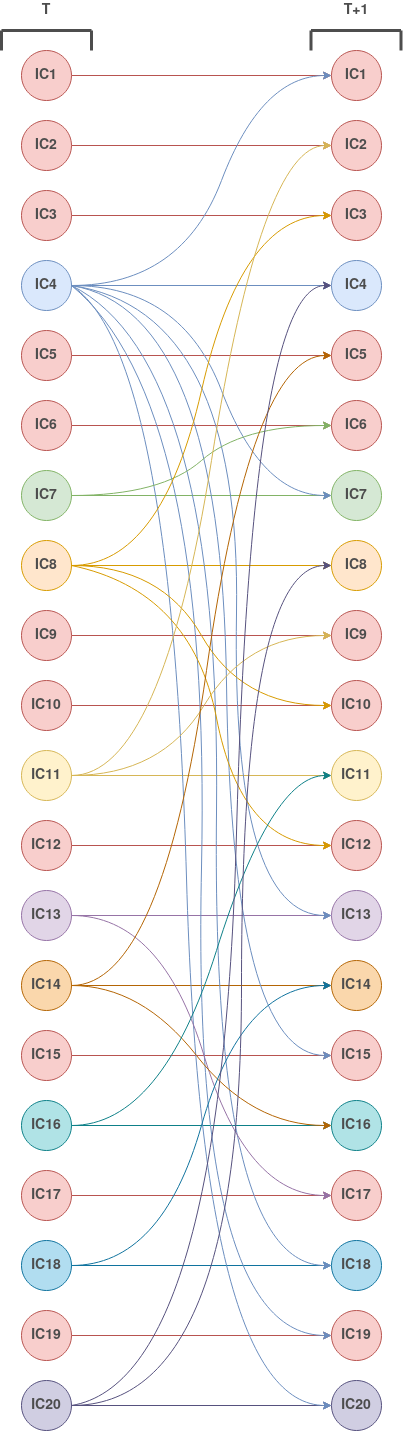

Now that the structure learnt using static BN is replicated in the dynamic BN, the CPTs must be also transferred.

In [17]:
from pgmpy.factors.discrete import TabularCPD
from functools import reduce
from operator import mul

# Mapping from any node to its original label
def get_dynamic_node(node):
    return (stat_to_dyn_map[node], 0) if node.endswith('_t') else (stat_to_dyn_map[next_to_curr_map[node]], 1)

# Extract information about CPDs of the static model
cpds_info = [{'variable': get_dynamic_node(cpd.variable),
              'variable_card': 4,
              'values': cpd.get_values(),
              'evidence': list(reversed([(stat_to_dyn_map[e], 0) for e in cpd.get_evidence()])) if len(cpd.get_evidence()) > 0 else None,
              'evidence_card': [4] * len(cpd.get_evidence()) if len(cpd.get_evidence()) > 0 else None,
              'state_names': dict([(get_dynamic_node(k), v) for k, v in cpd.state_names.items()])} for cpd in best_model.get_cpds()]

dynamic_cpds = [TabularCPD(**cpd_info) for cpd_info in cpds_info]
dynamic_model.add_cpds(*dynamic_cpds)

print(f'Model check: {dynamic_model.check_model()}')
print('-' * 25)
print('===== Time slice 0 =====')
for cpd in dynamic_model.get_cpds():
    print(f'CPT for {cpd.variable} node:')
    print(cpd, '\n')
print('===== Time slice 1 =====')
for cpd in dynamic_model.get_cpds(time_slice=1):
    print(f'CPT for {cpd.variable} node:')
    print(cpd, '\n')

Model check: True
-------------------------
===== Time slice 0 =====
CPT for ('IC16', 0) node:
+------------------------+-----------+
| ('IC16', 0)(High)      | 0.443503  |
+------------------------+-----------+
| ('IC16', 0)(Low)       | 0.358757  |
+------------------------+-----------+
| ('IC16', 0)(Very High) | 0.132768  |
+------------------------+-----------+
| ('IC16', 0)(Very Low)  | 0.0649718 |
+------------------------+-----------+ 

CPT for ('IC3', 0) node:
+-----------------------+-----------+
| ('IC3', 0)(High)      | 0.443503  |
+-----------------------+-----------+
| ('IC3', 0)(Low)       | 0.347458  |
+-----------------------+-----------+
| ('IC3', 0)(Very High) | 0.0819209 |
+-----------------------+-----------+
| ('IC3', 0)(Very Low)  | 0.127119  |
+-----------------------+-----------+ 

CPT for ('IC19', 0) node:
+------------------------+-----------+
| ('IC19', 0)(High)      | 0.313559  |
+------------------------+-----------+
| ('IC19', 0)(Low)       | 0.437853  |
+

## Network Analysis

In [21]:
dynamic_model.local_independencies([('IC4', 1)])

TypeError: sequence item 1: expected str instance, int found

## References
<a name="first">[1]</a> [Richardson et al. - Development of the social brain from age three totwelve years](https://www.nature.com/articles/s41467-018-03399-2.pdf)

<a name="second">[2]</a> [Varoquaux et al. - CanICA: Model-based extraction of reproduciblegroup-level ICA patterns from fMRI time series](https://arxiv.org/pdf/0911.4650.pdf)

<a name="third">[3]</a> [Burge et al. - Discrete Dynamic Bayesian Network Analysis of fMRI data](https://www.sciencedirect.com/science/article/pii/S0888613X1300073X)

<a name="fourth">[4]</a> [De Campos et al. - Efficient Structure Learning of Bayesian Networks using Constraints](https://jmlr.org/papers/volume12/decampos11a/decampos11a.pdf)